### Lab: Navigating the Lunar Lander with a Dueling Deep Q Network

### University of Virginia
### Reinforcement Learning
#### Last updated: February 27, 2024

---

#### Instructions:

You will work with the `LunarLander-v2` environment from `gymnasium` in this lab.  
An overview of the environment can be found [here](https://www.gymlibrary.dev/environments/box2d/lunar_lander/).  
If you're curious about the source code, see [here](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py).

Your mission will be to implement a dueling deep Q -network using PyTorch.  
You might run this on Colab.

There are a few specific tasks outlined below for you to solve.

The bigger tasks will be to:

- Show that the algorithm works to train the agent in the environment
- Run episodes and show the results

**Submission**  
As you will likely have several files including this notebook, you can zip all files and submit.

---

![lunar](https://github.com/tylergorecki/reinforcement_learning/blob/mywork/06_deep_q_networks_extensions/lunar_lander1.png?raw=1)

#### TOTAL POINTS: 12

---

**Hint:** Modules you may need to install include:

swig  
gym[box2d]  
gymnasium

#### 1) What is the penalty for crashing?  
**(POINTS: 1)**


-100 points

#### 2) Set up the environment and run 2 steps by taking random actions.
**(POINTS: 1)**

Note: used LunarLander-v3 because it said v2 was deprecated

In [10]:
import gymnasium as gym
import numpy as np

env = gym.make("LunarLander-v3")
env.reset(seed = 7540)

print('State shape:', env.observation_space.shape)
print('Num actions:', env.action_space.n)

rewards = list()

for i in range(2):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)

print('Average rewards with two random steps:', round(np.mean(rewards), 2))

State shape: (8,)
Num actions: 4
Average rewards with two random steps: -0.82


#### 3) Briefly discuss your approach to solving the problem  
**(POINTS: 2)**

The basic approach is to create a couple of neural network layers processing the data before creating a split that calculates the value and advantages of multiple states and actions. These separate values are then combined to create the Q-values, which are used to learn over time. The goal is for the environment to be understood enough by the agent that we are able to consistently have successful safe landings by the lunar object when testing it using the fully trained agent.

#### 4) Create supporting code files (`.py` format) to create the agent, train, and run episodes
**(POINTS: 6)**

Your code should include:

- **(POINTS: 1)** A class for the dueling DQN agent
- **(POINTS: 1)** An architecture with separate Value and Advantage streams
- **(POINTS: 1)** A method called `forward()` for the forward pass of the algorithm
- **(POINTS: 1)** A replay buffer
- **(POINTS: 1)** A training function
- **(POINTS: 1)** A function to run episodes

Setup

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import gymnasium as gym
import imageio

model_path = 'dueling_dqn_model.pth'

Class for dueling DQN agent with separate value and advantage streams and a forward() function

In [81]:
# Dueling DQN agent class
class DuelingDQN(nn.Module):
    def __init__(self, n_state, n_action, hidden_1=64, hidden_2=64, hidden_3=64):
        super(DuelingDQN, self).__init__()
        self.n_state = n_state

        # base stream
        self.dense_1 = nn.Linear(n_state, hidden_1)
        self.dense_2 = nn.Linear(hidden_1, hidden_2)

        # value stream
        self.value_1 = nn.Linear(hidden_2, hidden_3)
        self.value_2 = nn.Linear(hidden_3, 1)

        # advantage stream
        self.advantage_1 = nn.Linear(hidden_2, hidden_3)
        self.advantage_2 = nn.Linear(hidden_3, n_action)

    def forward(self, state):

        # calculate base stream output
        dense_1_out = torch.relu(self.dense_1(state))
        dense_2_out = torch.relu(self.dense_2(dense_1_out))

        # calculate values
        value_1_out = torch.relu(self.value_1(dense_2_out))
        value_2_out = self.value_2(value_1_out)

        # calculate advantages
        advantage_1_out = torch.relu(self.advantage_1(dense_2_out))
        advantage_2_out = self.advantage_2(advantage_1_out)

        # calculate mean advantage
        advantage_mean = torch.mean(advantage_2_out, dim=1, keepdim=True)

        # q values = difference between advantages and mean advantage + values
        q_values = advantage_2_out - advantage_mean + value_2_out

        return q_values

Replay buffer class

In [82]:
class ReplayBuffer:
    def __init__(self, capacity):
        # setup double ended queue
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        # add state transition to replay buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        # sample batch of transitions from all replay buffers
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), np.array(next_states), np.array(dones, dtype=np.float32)

    def __len__(self):
        # return length of replay buffer
        return len(self.buffer)

Training function

In [83]:
def train(agent, target_agent, replay_buffer, optimizer, gamma, batch_size):
    # if batch size is greater than the size of the replay buffer then we can't sample enough
    if len(replay_buffer) < batch_size:
        return

    # sample from replay buffer, convert each list of values to tensors
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)

    # get the q values for each of the states
    q_values = agent(states)
    q_values_next = target_agent(next_states).detach()
    # calculate the target q values
    q_values_target = rewards + gamma * torch.max(q_values_next, dim=1)[0] * (1 - dones)
    q_values_selected = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    # calculate the loss between the target q values and the samples q values
    loss = nn.MSELoss()(q_values_target, q_values_selected)

    # reset gradients
    optimizer.zero_grad()
    # compute gradients based on the calculated loss
    loss.backward()
    # update model using computed gradients
    optimizer.step()

Function to run episodes

In [84]:
def run_episode(env, agent, target_agent, replay_buffer, optimizer, gamma, batch_size, epsilon, render=False, video_frames=None):
    # in each episode, reset env and go through a step
    state, _ = env.reset()
    state = np.array(state)
    done = False
    total_reward = 0

    # in case I want to render a specific run
    while not done:
        if render:
            frame = env.render()
            if video_frames is not None:
                video_frames.append(frame)

        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = agent(state_tensor)
            action = torch.argmax(q_values).item()

        next_state, reward, done, truncated, _ = env.step(action)
        next_state = np.array(next_state)
        done = done or truncated
        # add transition to replay buffer
        replay_buffer.add(state, action, reward, next_state, done)
        # call train function which computes gradients using replay buffer
        train(agent, target_agent, replay_buffer, optimizer, gamma, batch_size)

        state = next_state
        total_reward += reward

    if render:
        frame = env.render()
        if video_frames is not None:
            video_frames.append(frame)

    # return summed rewards from all steps
    return total_reward

Testing function

In [ ]:
def test_dueling_dqn(env_name="LunarLander-v3", episodes=200, batch_size=32, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, target_update_freq=10, render_episode=None, video_filename="dueling_dqn_video.mp4"):
    # setup environment
    env = gym.make(env_name, render_mode=None)
    n_state = env.observation_space.shape[0]
    n_action = env.action_space.n

    # setup inline policy and target policy
    agent = DuelingDQN(n_state, n_action)
    target_agent = DuelingDQN(n_state, n_action)
    target_agent.load_state_dict(agent.state_dict())
    optimizer = optim.Adam(agent.parameters(), lr=0.001)
    replay_buffer = ReplayBuffer(capacity=10000)

    epsilon = epsilon_start
    # track rewards
    rewards = []

    # loop through episodes while updating policy
    for episode in range(episodes):
        video_frames = [] if episode == render_episode else None
        reward = run_episode(env, agent, target_agent, replay_buffer, optimizer, gamma, batch_size, epsilon, render=(episode == render_episode), video_frames=video_frames)
        rewards.append(reward)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if episode % target_update_freq == 0:
            target_agent.load_state_dict(agent.state_dict())

        if episode % 10 == 0:
            print(f"Episode {episode}, Reward: {reward}, Epsilon: {epsilon}")

        if episode == render_episode and video_frames:
            imageio.mimsave(video_filename, video_frames, fps=30)
            print(f"Video saved to {video_filename}")

    env.close()
    # save agent to colab
    torch.save(agent.state_dict(), model_path)
    # return list of rewards
    return rewards

#### 5) Run the training and show evidence that the agent is learning.  

For example, its average reward (score) should increase with more episodes.

**(POINTS: 1 if successful)**

In [75]:
rewards = test_dueling_dqn(episodes=500)

Episode 0, Reward: -129.43189674610653, Epsilon: 0.995
Episode 10, Reward: -306.13770876206587, Epsilon: 0.946354579813443
Episode 20, Reward: -84.04039963030368, Epsilon: 0.9000874278732445
Episode 30, Reward: -53.65971597840208, Epsilon: 0.8560822709551227
Episode 40, Reward: -114.8068121792671, Epsilon: 0.8142285204175609
Episode 50, Reward: -96.3181118868087, Epsilon: 0.7744209942832988
Episode 60, Reward: -85.79802988319562, Epsilon: 0.736559652908221
Episode 70, Reward: -159.01610522132233, Epsilon: 0.7005493475733617
Episode 80, Reward: -116.04945363302414, Epsilon: 0.6662995813682115
Episode 90, Reward: -57.65392839765889, Epsilon: 0.6337242817644086
Episode 100, Reward: -47.696565588403686, Epsilon: 0.6027415843082742
Episode 110, Reward: -16.96743230893162, Epsilon: 0.5732736268885887
Episode 120, Reward: -63.12709059465428, Epsilon: 0.5452463540625918
Episode 130, Reward: -65.86005860964836, Epsilon: 0.5185893309484582
Episode 140, Reward: 21.21187673607551, Epsilon: 0.49323

Below shows the plot of the rewards, averaged over time

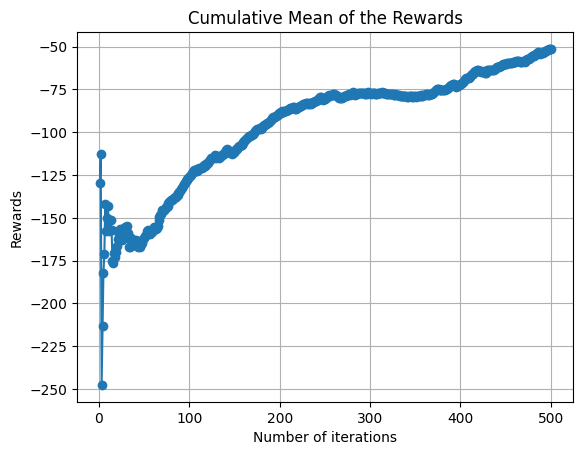

In [76]:
import matplotlib.pyplot as plt

cumulative_means = []
temp_list = []
for i, num in enumerate(rewards):
    temp_list.append(num)
    cumulative_mean = sum(temp_list) / len(temp_list)
    cumulative_means.append(cumulative_mean)

plt.plot(range(1, len(rewards) + 1), cumulative_means, marker='o')
plt.xlabel("Number of iterations")
plt.ylabel("Rewards")
plt.title("Cumulative Mean of the Rewards")
plt.grid(True)
plt.show()

The plot above shows that the average reward does increase over time, but it does not converge to values above/around 200 in the 500 iterations (I guess the mean would take much longer to reach that 200 mark). I am not sure what I should have changed to get this to converge faster, but there's promise in the existing implementation. If I had more time, I would try to decrease the epsilon decay to allow for more exploration longer. I typically find that it helps with the output but there does not seem to be a strong enough increase in performance yet. With this being said, though, I am unfortunately coming up on the deadline so I won't be able to change that for my submission.

#### 6) Run a few episodes and show results
**(POINTS: 1 if successful)**

Code in the function is the same as training above except for the one part where it's noted. There, I am loading the agent with the developed policy from the completed training instead of creating a new one again.

In [77]:
def run_trained_policy(env_name="LunarLander-v3", model_path="dueling_dqn_model.pth", render=True, num_episodes=5, video_filename="trained_policy_video.mp4"):
    # setup environment
    env = gym.make(env_name, render_mode='rgb_array')
    n_state = env.observation_space.shape[0]
    n_action = env.action_space.n

    # AGENT LOADED HERE INSTEAD OF CREATING NEW ONE
    agent = DuelingDQN(n_state, n_action)
    agent.load_state_dict(torch.load(model_path))
    agent.eval()

    # loop through episodes with given policy
    for episode in range(num_episodes):
        state, _ = env.reset()
        state = np.array(state)
        done = False
        total_reward = 0
        video_frames = []

        # take steps until done
        while not done:
            # render last episode
            if render and episode == num_episodes -1:
                frame = env.render()
                video_frames.append(frame)

            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = agent(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, done, truncated, info = env.step(action)
            next_state = np.array(next_state)
            done = done or truncated

            state = next_state
            total_reward += reward

        print(f"Episode {episode + 1}, Total Reward: {total_reward}")

        # save video of last episode
        if episode == num_episodes - 1 and render:
            imageio.mimsave(video_filename, video_frames, fps=30)
            print(f"Video saved to {video_filename}")

    env.close()

In [78]:
run_trained_policy()

<ipython-input-77-a00606641798>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.load_state_dict(torch.load(model_path))


Episode 1, Total Reward: 218.97864911495606
Episode 2, Total Reward: 75.17471689183735
Episode 3, Total Reward: -76.40929137487903
Episode 4, Total Reward: 126.38795603696818


Episode 5, Total Reward: 244.90663379596347
Video saved to trained_policy_video.mp4


The rewards shown above reiterate what I discussed in question 5 where they are highly variable and not converged above to 200. These runs did hit 200 twice though which was promising for my last testing run. To improve this, would I set up my neural network differently or change a different part of the code implementation?

Also, just so it's noted, I gained inspiration from the following sources, existing Github code bases, and Generative AI software to properly implement the code and to understand the project better as a whole.
- https://gymnasium.farama.org/environments/box2d/lunar_lander/#observation-space
- https://medium.com/@sainijagjit/understanding-dueling-dqn-a-deep-dive-into-reinforcement-learning-575f6fe4328c
- https://github.com/gouxiangchen/dueling-DQN-pytorch/blob/master/dueling_dqn.py
- https://github.com/ejmejm/Q-Learning-Tutorials/blob/master/Dueling_Double_DQN.ipynb
- https://github.com/ChienTeLee/dueling_dqn_lunar_lander/blob/master/Dueling_DQN_with_Prioritized_Experience_Replay.ipynb
- ChatGPT
- Google Gemini